In [1]:
cd("../../../temp")

In [2]:
]activate temp

  Activating project at `c:\Users\Work\Documents\Personal\Work\classes\PUCP 2024-II\repo\temp\temp`


Note: The following code will be necessary to use decision trees with the MLJ package 

In [3]:
# ]add RDatasets DataFrames MLJDecisionTreeInterface DecisionTree StatsPlots

# PD 9: Decision and Regression Trees

Today we will be seeing our first non-parametric prediction model: the trees. Trees work by splitting sets of observations by setting a threshold value for a selected feature, such that it minimizes either the variance (in regression settings) or the diversity (in classification settings) of the subsets generated.

## Classification

We will start with a classification example: first we will 

In [4]:
using RDatasets, DataFrames
iris = dataset("datasets", "iris")
iris[1:5,:]

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


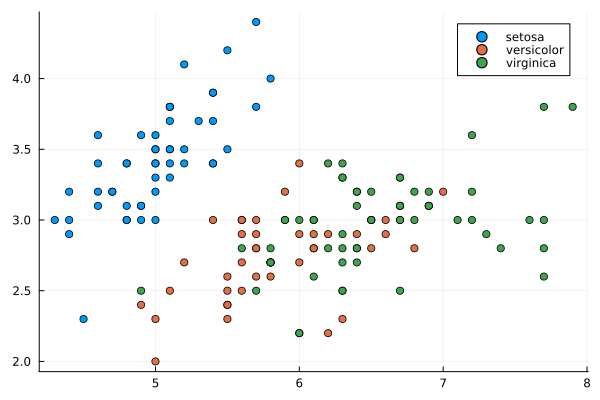

In [5]:
using Plots, StatsPlots

@df iris scatter(
        :SepalLength,
        :SepalWidth,
        group = :Species
)

In [6]:
using MLJ # using the MLJ framework

y, X = unpack(iris, ==(:Species), !=(:Species))
train, test = partition(eachindex(y), 0.9, shuffle = true, rng = 123);

In [7]:
using MLJModels # loads the modesl MLJ can use e.g. linear regression, decision tree
tree_model = (@load DecisionTreeClassifier pkg=DecisionTree verbosity=0)()
tree_machine = machine(tree_model, X[train, :], y[train])
fit!(tree_machine);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


In [8]:
fitted_params(tree_machine)[1]

PetalWidth < 0.8
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ PetalLength < 4.95
   │  ├─ PetalWidth < 1.65
   │  │  ├─ versicolor (45/45)
   │  │  └─ virginica (1/1)
   │  └─ PetalWidth < 1.55
   │     ├─ virginica (3/3)
   │     └─ SepalLength < 6.95
   │        ├─ versicolor (2/2)
   │        └─ virginica (1/1)
   └─ PetalLength < 4.85
      ├─ SepalLength < 6.05
      │  ├─ versicolor (1/1)
      │  └─ virginica (1/1)
      └─ virginica (36/36)


In [9]:
predictions = predict_mode(tree_machine, X[test, :])
mean(predictions .== y[test])

0.9333333333333333

In [10]:
DecisionTreeClassifier = (@load DecisionTreeClassifier pkg=DecisionTree verbosity=0)
tree_model_prune = DecisionTreeClassifier(post_prune = true, merge_purity_threshold = 0.6)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


In [11]:
fitted_params(tree_machine_prune)[1]

PetalWidth < 0.8
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ versicolor (47/52)
   └─ PetalLength < 4.85
      ├─ SepalLength < 6.05
      │  ├─ versicolor (1/1)
      │  └─ virginica (1/1)
      └─ virginica (36/36)


In [12]:
pruned_predictions = predict_mode(tree_machine_prune, X[test, :])
mean(pruned_predictions .== y[test])

0.9333333333333333

In [13]:
tree = DecisionTreeClassifier(post_prune = true, merge_purity_threshold = 1)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


In [14]:
thresholds = collect(0.01:0.01:1)
innaccuracies = []

for threshold in thresholds
        tree.merge_purity_threshold = threshold
        evaluation = evaluate!(
                tree_machine_prune,
                resampling = CV(nfolds = 3, shuffle = true),
                measure = Accuracy()
        )
        innaccuracies = [innaccuracies; 1 .- evaluation.measurement]
end

Evaluating over 3 folds: 100%[=========================] Time: 0:00:02


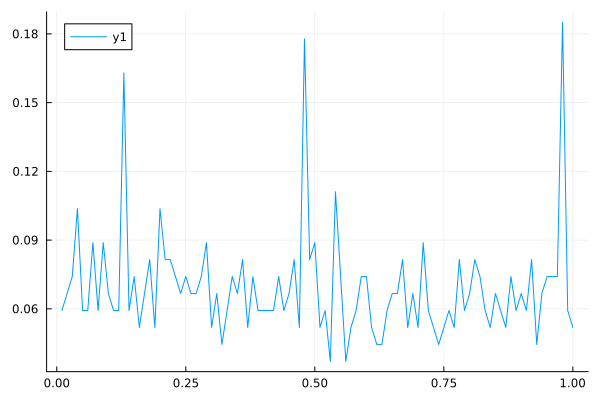

In [15]:
plot(thresholds, innaccuracies)

In [16]:
thresholds[argmin(innaccuracies)]

0.53

In [17]:
tree = DecisionTreeClassifier(post_prune = true, merge_purity_threshold = thresholds[argmin(innaccuracies)])
tree_machine_prune = machine(tree, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


In [18]:
fitted_params(tree_machine)[1]

PetalWidth < 0.8
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ PetalLength < 4.95
   │  ├─ PetalWidth < 1.65
   │  │  ├─ versicolor (45/45)
   │  │  └─ virginica (1/1)
   │  └─ PetalWidth < 1.55
   │     ├─ virginica (3/3)
   │     └─ SepalLength < 6.95
   │        ├─ versicolor (2/2)
   │        └─ virginica (1/1)
   └─ PetalLength < 4.85
      ├─ SepalLength < 6.05
      │  ├─ versicolor (1/1)
      │  └─ virginica (1/1)
      └─ virginica (36/36)


In [19]:
fitted_params(tree_machine_prune)[1]

PetalLength < 2.45
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ versicolor (47/52)
   └─ PetalLength < 4.85
      ├─ SepalWidth < 3.0
      │  ├─ virginica (1/1)
      │  └─ versicolor (1/1)
      └─ virginica (36/36)


In [20]:
pruned_predictions = predict_mode(tree_machine_prune, X[test, :])
mean(pruned_predictions .== y[test])

0.9333333333333333

## Regression

In [21]:
hitters = dataset("ISLR", "Hitters")
hitters[1:5, :]

Row,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Cat…,Cat…,Int32,Int32,Int32,Float64?,Cat…
1,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,missing,A
2,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
3,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
4,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
5,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [22]:
describe(hitters, :nmissing)

Row,variable,nmissing
,Symbol,Int64
1,AtBat,0
2,Hits,0
3,HmRun,0
4,Runs,0
5,RBI,0
6,Walks,0
7,Years,0
8,CAtBat,0
9,CHits,0


In [23]:
hitters = dropmissing(hitters, :Salary);

In [24]:
y, X = unpack(hitters, ==(:Salary), !=(:Salary));


In [25]:
schema(X)

┌───────────┬───────────────┬─────────────────────────────────┐
│ names     │ scitypes      │ types                           │
├───────────┼───────────────┼─────────────────────────────────┤
│ AtBat     │ Count         │ Int32                           │
│ Hits      │ Count         │ Int32                           │
│ HmRun     │ Count         │ Int32                           │
│ Runs      │ Count         │ Int32                           │
│ RBI       │ Count         │ Int32                           │
│ Walks     │ Count         │ Int32                           │
│ Years     │ Count         │ Int32                           │
│ CAtBat    │ Count         │ Int32                           │
│ CHits     │ Count         │ Int32                           │
│ CHmRun    │ Count         │ Int32                           │
│ CRuns     │ Count         │ Int32                           │
│ CRBI      │ Count         │ Int32                           │
│ CWalks    │ Count         │ Int32     

In [26]:
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:League, :Division, :NewLeague])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

[ Info: Training machine(OneHotEncoder(features = [:League, :Division, :NewLeague], …), …).
[ Info: Spawning 2 sub-features to one-hot encode feature :League.
[ Info: Spawning 2 sub-features to one-hot encode feature :Division.
[ Info: Spawning 2 sub-features to one-hot encode feature :NewLeague.


In [27]:
schema(X)

┌──────────────┬────────────┬─────────┐
│ names        │ scitypes   │ types   │
├──────────────┼────────────┼─────────┤
│ AtBat        │ Count      │ Int32   │
│ Hits         │ Count      │ Int32   │
│ HmRun        │ Count      │ Int32   │
│ Runs         │ Count      │ Int32   │
│ RBI          │ Count      │ Int32   │
│ Walks        │ Count      │ Int32   │
│ Years        │ Count      │ Int32   │
│ CAtBat       │ Count      │ Int32   │
│ CHits        │ Count      │ Int32   │
│ CHmRun       │ Count      │ Int32   │
│ CRuns        │ Count      │ Int32   │
│ CRBI         │ Count      │ Int32   │
│ CWalks       │ Count      │ Int32   │
│ League__A    │ Continuous │ Float64 │
│ League__N    │ Continuous │ Float64 │
│ Division__E  │ Continuous │ Float64 │
│ Division__W  │ Continuous │ Float64 │
│ PutOuts      │ Count      │ Int32   │
│ Assists      │ Count      │ Int32   │
│ Errors       │ Count      │ Int32   │
│ NewLeague__A │ Continuous │ Float64 │
│ NewLeague__N │ Continuous │ Float64 │


In [28]:
coerce!(X, Count => Continuous);

In [29]:
train, test = partition(eachindex(y), 0.9, rng = 1);

In [30]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)
tree_model = DecisionTreeRegressor()
tree_machine = machine(tree_model, X[train, :], y[train])
fit!(tree_machine);

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


In [31]:
fitted_params(tree_machine)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ CRuns < 64.0
│     │  │  ├─ Hits < 69.5
│     │  │  │  ⋮
│     │  │  │  
│     │  │  └─ Runs < 45.0
│     │  │     ⋮
│     │  │     
│     │  └─ CAtBat < 842.5
│     │     ├─ CRuns < 100.5
│     │     │  ⋮
│     │     │  
│     │     └─ PutOuts < 151.5
│     │        ⋮
│     │        
│     └─ CWalks < 120.0
│        ├─ Walks < 29.5
│        │  ├─ 318.9375 (0/8)
│        │  └─ 215.0 (2/7)
│        └─ Walks < 45.0
│           ├─ 338.5 (0/5)
│           └─ 447.22222222222223 (0/9)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ NewLeague__A < 0.5
   │  │  ├─ Years < 12.5
   │  │  │  ├─ CRuns < 414.0
   │  │  │  │  ⋮
   │  │  │  │  
   │  │  │  └─ PutOuts < 118.0
   │  │  │     ⋮
   │  │  │     
   │  │  └─ Hits < 76.5
   │  │     ├─ Errors < 5.5
   │  │     │  ⋮
   │  │     │  
   │  │     └─ 500.4166666666667 (0/6)
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ CWalks 

In [32]:
predictions = predict(tree_machine, X[test, :])
sqrt(mean((predictions - y[test]) .^ 2))

212.79287325701367

In [33]:
tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = 0.1)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


In [34]:
fitted_params(tree_machine_prune)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ 75.0 (5/40)
│     │  └─ CAtBat < 842.5
│     │     ├─ 155.0 (2/14)
│     │     └─ 250.0 (2/15)
│     └─ 350.0 (3/29)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ 450.0 (4/39)
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ CWalks < 177.0
   │     │  │  ⋮
   │     │  │  
   │     │  └─ 850.0 (4/38)
   │     └─ 1156.6666666666667 (0/6)
   └─ RBI < 73.5
      ├─ PutOuts < 239.5
      │  ├─ 1156.0714285714287 (0/7)
      │  └─ 875.0 (2/14)
      └─ Years < 13.5
         ├─ CHits < 1055.0
         │  ├─ 1118.5714285714287 (0/7)
         │  └─ 2028.0118333333332 (0/6)
         └─ 992.4654999999999 (0/6)


In [35]:
predictions_prune = predict(tree_machine_prune, X[test, :])
sqrt(mean((predictions_prune - y[test]) .^ 2))

181.76459093051906

In [36]:
thresholds = collect(0.01:0.01:1)
rmses = []

for threshold in thresholds
        tree_model_prune.merge_purity_threshold = threshold
        evaluation = evaluate!(
                tree_machine_prune,
                resampling = CV(nfolds = 3, shuffle = true),
                measure = rmse
        )
        rmses = [rmses; evaluation.measurement]
end

Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


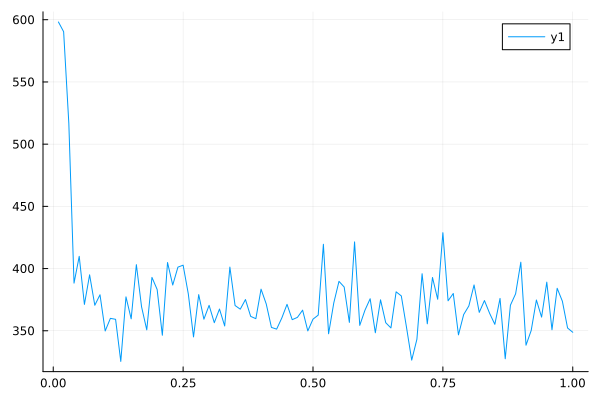

In [37]:
plot(thresholds, rmses)

In [38]:
tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = thresholds[argmin(rmses)])
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


In [39]:
predictions_prune = predict(tree_machine_prune, X[test, :])
sqrt(mean((predictions_prune - y[test]) .^ 2))

212.96996788579298